In [1]:
pip install ktrain

     |████████████████████████████████| 25.3MB 129kB/s 
     |████████████████████████████████| 983kB 48.3MB/s 
     |████████████████████████████████| 245kB 51.3MB/s 
     |████████████████████████████████| 890kB 53.2MB/s 
     |████████████████████████████████| 471kB 55.7MB/s 
     |████████████████████████████████| 1.1MB 38.2MB/s 
     |████████████████████████████████| 890kB 48.6MB/s 
     |████████████████████████████████| 3.0MB 44.1MB/s 
  Created wheel for ktrain: filename=ktrain-0.21.3-cp36-none-any.whl size=25270203 sha256=0dfcde922c23dd85942d16b9e1b844d8f2259497021d40eadd023c29cee4e702
  Stored in directory: /root/.cache/pip/wheels/d6/ef/6d/9428365b27ac1e84a77214c5718e7f8b2180007af593791247
  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp36-none-any.whl size=34145 sha256=b4e0fcf4914607780a69982d7ebcba9931d6aca24082cce8d61589a3a33384f7
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for lan

In [2]:
import ktrain
from ktrain import text
import pandas as pd
import numpy as np
from sklearn.utils import shuffle, resample

Load the data

In [3]:
news = pd.read_csv("/content/drive/My Drive/CSV/news_preprocessed_with_addtionalLabel.csv", index_col=0)

In [4]:
# Get the same train and test data
def split_df_in_train_test(df):
    df = df.reset_index()
    split_point = int(np.round(df.shape[0]) * 0.8)
    df_train = df.loc[:split_point-1,:]
    df_test = df.loc[split_point:,:]
    return df_train, df_test

In [5]:
left_AbSt_01 = resample(shuffle(news[(news["Label_AbStudy_01"]=="Left") & (news["Length"]<512)], random_state=42), \
         random_state=42, n_samples=25000)
center_AbSt_01 = resample(shuffle(news[(news["Label_AbStudy_01"]=="Center") & (news["Length"]<512)], random_state=42), \
         random_state=42, n_samples=25000)
right_AbSt_01 = resample(shuffle(news[(news["Label_AbStudy_01"]=="Right") & (news["Length"]<512)], random_state=42), \
         random_state=42, n_samples=25000)

In [6]:
train = pd.concat([split_df_in_train_test(left_AbSt_01)[0], \
    split_df_in_train_test(center_AbSt_01)[0], \
    split_df_in_train_test(right_AbSt_01)[0]])

test = pd.concat([split_df_in_train_test(left_AbSt_01)[1], \
    split_df_in_train_test(center_AbSt_01)[1], \
    split_df_in_train_test(right_AbSt_01)[1]])

In [7]:
x_train = train["content"].to_list()
y_train = train["Label_AbStudy_01"].to_list()
x_test = test["content"].to_list()
y_test = test["Label_AbStudy_01"].to_list()

In [8]:
class_names = list(train["Label_AbStudy_01"].unique())

Apply the model

In [9]:
model_name = "roberta-base"

In [10]:
t = text.Transformer(model_name, maxlen=512, class_names=class_names)

In [11]:
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 252
	95percentile : 482
	99percentile : 506


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:573: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 250
	95percentile : 483
	99percentile : 505


In [12]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

simulating training for different learning rates... this may take a few moments...
10000/10000 [==============================] - 8197s 820ms/step - loss: 10.7389 - accuracy: 0.4301


done.
Visually inspect loss plot and select learning rate associated with falling loss


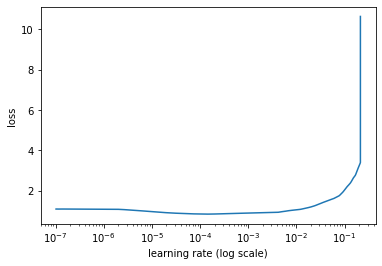

In [13]:
learner.lr_find(show_plot=True, max_epochs=1)

In [14]:
optimal_lr = learner.lr_estimate()[1]
print(optimal_lr)

1.2989742390345783e-05


In [15]:
learner.fit(optimal_lr, 1)

10000/10000 [==============================] - 8999s 900ms/step - loss: 0.3977 - accuracy: 0.8391 - val_loss: 0.3050 - val_accuracy: 0.8857


In [16]:
learner.validate(class_names=class_names)

              precision    recall  f1-score   support

        Left       0.93      0.92      0.93      5000
      Center       0.80      0.94      0.86      5000
       Right       0.95      0.80      0.87      5000

    accuracy                           0.89     15000
   macro avg       0.90      0.89      0.89     15000
weighted avg       0.90      0.89      0.89     15000



array([[4586,  366,   48],
       [ 142, 4718,  140],
       [ 180,  839, 3981]])